In [1]:
import os
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, cohen_kappa_score
from keras.models import Model
from keras import optimizers, applications
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input

In [2]:
train = pd.read_csv('/content/drive/MyDrive/Explainability Exercise/data/train.csv')
test = pd.read_csv('/content/drive/MyDrive/Explainability Exercise/data/test.csv')
print('Number of train samples: ', train.shape[0])
print('Number of test samples: ', test.shape[0])

# Preprocecss data
train["id_code"] = train["id_code"].apply(lambda x: x + ".png")
test["id_code"] = test["id_code"].apply(lambda x: x + ".png")
train['diagnosis'] = train['diagnosis'].astype('str')
test['diagnosis'] = test['diagnosis'].astype('str')
display(train.head())
display(test.head())

Number of train samples:  3662
Number of test samples:  1928


,id_code,age,gender,diagnosis
0,000c1434d8d7.png,64,F,2
1,001639a390f0.png,78,F,4
2,0024cdab0c1e.png,76,F,1
3,002c21358ce6.png,47,M,0
4,005b95c28852.png,26,F,0


,id_code,age,gender,diagnosis
0,0005cfc8afb6.png,56,F,1
1,003f0afdcd15.png,21,F,3
2,006efc72b638.png,60,F,1
3,00836aaacf06.png,25,M,3
4,009245722fa4.png,77,F,2


In [3]:
# Model parameters
BATCH_SIZE = 8
HEIGHT = 320
WIDTH = 320
CANAL = 3
N_CLASSES = train['diagnosis'].nunique()

In [4]:
X_train, X_val = train_test_split(train, test_size=0.2)

In [5]:
train_datagen=ImageDataGenerator(rescale=1./255,
                                 rotation_range=360,
                                 horizontal_flip=True,
                                 vertical_flip=True)

train_generator=train_datagen.flow_from_dataframe(
    dataframe=X_train,
    directory="/content/drive/MyDrive/Explainability Exercise/data/train_images/",
    x_col="id_code",
    y_col="diagnosis",
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    target_size=(HEIGHT, WIDTH),
    seed=0)

validation_datagen = ImageDataGenerator(rescale=1./255)

valid_generator=validation_datagen.flow_from_dataframe(
    dataframe=X_val,
    directory="/content/drive/MyDrive/Explainability Exercise/data/train_images/",
    x_col="id_code",
    y_col="diagnosis",
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    target_size=(HEIGHT, WIDTH),
    seed=0)

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(
        dataframe=test,
        directory = "/content/drive/MyDrive/Explainability Exercise/data/test_images/",
        x_col="id_code",
        y_col="diagnosis",
        class_mode="categorical",
        batch_size=BATCH_SIZE,
        target_size=(HEIGHT, WIDTH),
        seed=0)

Found 2927 validated image filenames belonging to 5 classes.
Found 730 validated image filenames belonging to 5 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 2 invalid image filename(s) in x_col="id_code". These filename(s) will be ignored.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 3 invalid image filename(s) in x_col="id_code". These filename(s) will be ignored.
  warnings.warn(


Found 1927 validated image filenames belonging to 5 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 1 invalid image filename(s) in x_col="id_code". These filename(s) will be ignored.
  warnings.warn(


In [6]:
model = tf.keras.models.load_model("/content/drive/MyDrive/Explainability Exercise/model.h5")

In [7]:
STEP_SIZE_TEST = test_generator.n//test_generator.batch_size

# Create empty arays to keep the predictions and labels
lastFullTestPred = np.empty((0, N_CLASSES))
lastFullTestLabels = np.empty((0, N_CLASSES))

# Add test predictions and labels
for i in range(STEP_SIZE_TEST+1):
    im, lbl = next(test_generator)
    scores = model.predict(im, batch_size=test_generator.batch_size)
    lastFullTestPred = np.append(lastFullTestPred, scores, axis=0)
    lastFullTestLabels = np.append(lastFullTestLabels, lbl, axis=0)

test_preds = [np.argmax(pred) for pred in lastFullTestPred]
test_labels = [np.argmax(label) for label in lastFullTestLabels]

1/1 [==============================] - 3s 3s/step


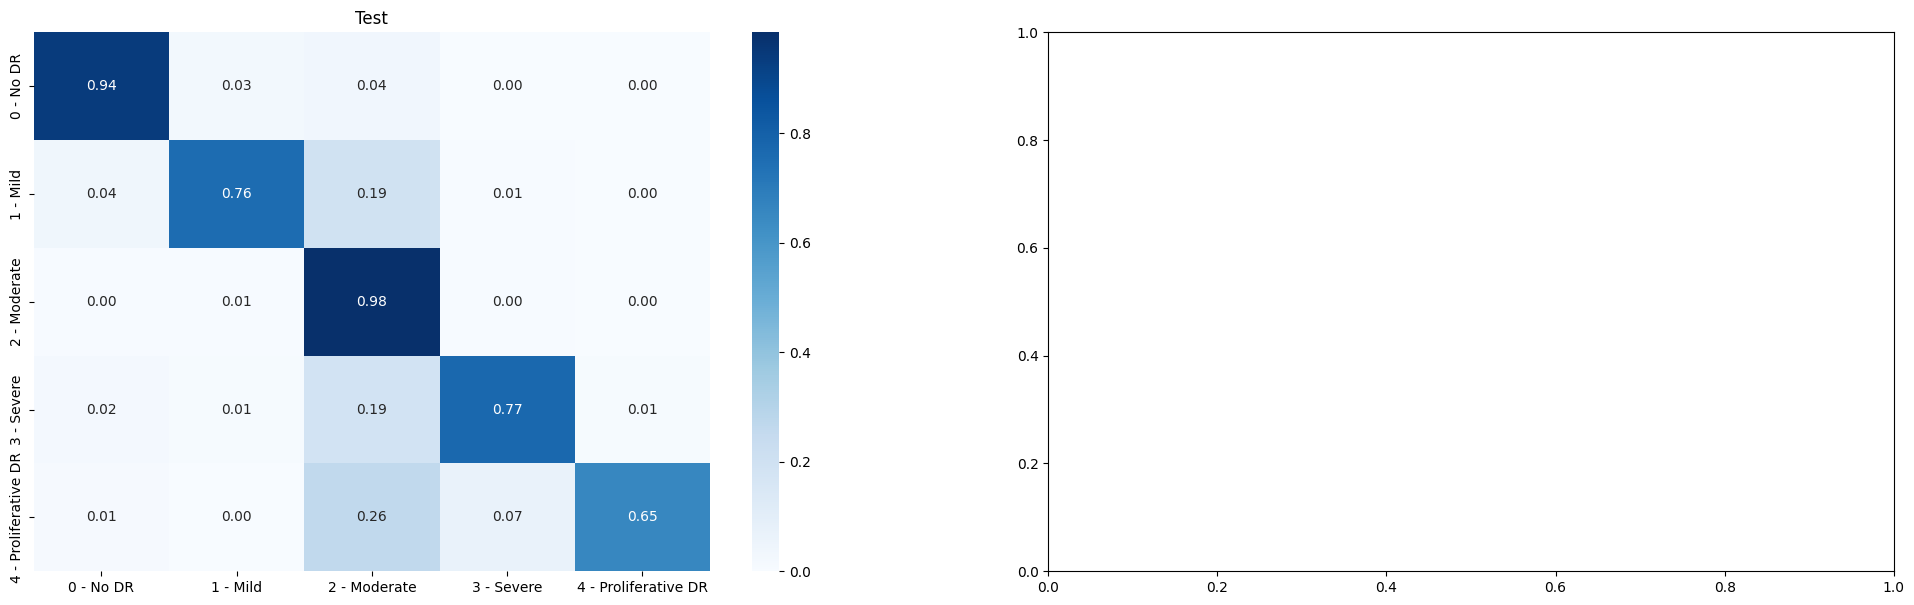

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharex='col', figsize=(24, 7))
labels = ['0 - No DR', '1 - Mild', '2 - Moderate', '3 - Severe', '4 - Proliferative DR']
test_cnf_matrix = confusion_matrix(test_labels, test_preds)

test_cnf_matrix_norm = test_cnf_matrix.astype('float') / test_cnf_matrix.sum(axis=1)[:, np.newaxis]

test_df_cm = pd.DataFrame(test_cnf_matrix_norm, index=labels, columns=labels)

sns.heatmap(test_df_cm, annot=True, fmt='.2f', cmap="Blues", ax=ax1).set_title('Test')
plt.show()

In [12]:
print("Test Cohen Kappa score: %.3f" % cohen_kappa_score(test_preds,test_labels, weights='quadratic'))

Test Cohen Kappa score: 0.896
